### Preparation steps : How to get to the data?

1. **Initialize the necessary variables to connect to the API.**
2. **Explore and analyze the data provided by the network.**
3. **Retrieve the files of interest for further processing.**

In [11]:
import os 
import json
import jwt
import time
import requests
from pathlib import Path
import subprocess
import matplotlib.pyplot as plt
from datetime import datetime
import xarray as xr
import rioxarray as rio

**If the data is not predownloaded, this step is necessary to connect to the server CLMS side.**

In [35]:
# generate private token
working_dir = os.getcwd()

config = {
    "start_date":"2014-01-01",
    "end_date":datetime.now().strftime("%Y-%m-%d"),
    "bounding_box":{"y_min": -19.6, "y_max": -18.1, "x_min": 32.9, "x_max": 34.4,},
    "api_url":"https://land.copernicus.eu",
    "dataset_analysed":"fapar",
    "dataset_key":"FCOVER",
    "threshold":0.15
    }

# API token management
token_file_path = os.path.join(working_dir, 'token.json')
service_key = json.load(open(token_file_path, 'r'))
private_key = service_key['private_key'].encode('utf-8')

claim_set = {
    "iss": service_key['client_id'],
    "sub": service_key['user_id'],
    "aud": service_key['token_uri'],
    "iat": int(time.time()),
    "exp": int(time.time() + (60 * 60 * 24)), # 24 hours
    }
grant = jwt.encode(claim_set, private_key, algorithm='RS256')
result = requests.post(
service_key["token_uri"],
    headers={
        "Accept": "application/json",
        "Content-Type": "application/x-www-form-urlencoded",
        },
    data={
        "grant_type": "urn:ietf:params:oauth:grant-type:jwt-bearer",
        "assertion": grant,
    },
)
access_token_info_json = result.json()
access_token = access_token_info_json.get('access_token')
print(f"Access token: {access_token}")



Access token: None


**Here, extract the dataset available**
We can print the title of all the datasets and find the ones we need.


In [ ]:
# Construct the URL
url = f"{config["api_url"]}/api/@search?portal_type=DataSet&metadata_fields=UID&metadata_fields=dataset_full_format&metadata_fields=dataset_download_information&b_size=1000"

# Set headers
headers = {
    "Accept": "application/json"
}

# Make the GET request
response = requests.get(url, headers=headers)

# Check if successful
if response.status_code == 200:
    # Parse the JSON response
    data_json = response.json()
    # Optionally store the full JSON string as well
    full_metadata = response.text
else:
    print(f"Request failed with status code {response.status_code}")
    print(response.text)

for data in data_json['items']:
        print(data["title"])

NameError: name 'config' is not defined

We can browse through the available dataset, and extract the one we're interested in.
Extracting the data essentially means: generating an URL geared towards the file needed.

In [ ]:
data_we_want = "Leaf Area Index 2014-present"
data_we_want = "Fraction of Green Vegetation Cover 2014-present (raster 300 m), global, 10-daily – version 1"


for data in data_json['items']:
    if data_we_want in data["title"]:
        # Print the title of the dataset
        full_dataset_name = data["title"]

print(f"Full dataset name: {full_dataset_name}")

# now generate the wget command to download the dataset
for data in data_json['items']:
    if data['title'] == full_dataset_name:
        # get api information
        uid_dataset = data['UID']
        atid_dataset = data['dataset_download_information']['items'][0]["@id"]

full_api_url = f"{config["api_url"]}/api/@get-download-file-urls?" \
               f"dataset_uid={uid_dataset}" \
               f"&download_information_id={atid_dataset}" \
               f"&date_from={config["start_date"]}" \
               f"&date_to={config["end_date"]}" \
               f"&x_min={config["bounding_box"]['x_min']}" \
               f"&x_max={config["bounding_box"]['x_max']}" \
               f"&y_min={config["bounding_box"]['y_min']}" \
               f"&y_max={config["bounding_box"]['y_max']}"
print(f"Full API URL: {full_api_url}")
# Build the API call to download the data
download_links_json_call = requests.get(
    full_api_url,
    headers={'Accept': 'application/json', 'Authorization': f'Bearer {access_token}'}
    ).json()


#
for files in download_links_json_call:
    print(files)

Full dataset name: Fraction of Green Vegetation Cover 2014-present (raster 300 m), global, 10-daily – version 1
Full API URL: https://land.copernicus.eu/api/@get-download-file-urls?dataset_uid=4877d6b19005405eac7799497a28d65e&download_information_id=e76c7c67-e0dd-43f3-b7bb-436c64566057&date_from=2014-01-01&date_to=2025-07-28&x_min=32.9&x_max=34.4&y_min=-19.6&y_max=-18.1
https://globalland.vito.be/download/netcdf/fraction_green_cover/fcover_300m_v1_10daily/2016/20160910/c_gls_FCOVER300-RT0_201609100000_GLOBE_PROBAV_V1.0.1.nc
https://globalland.vito.be/download/netcdf/fraction_green_cover/fcover_300m_v1_10daily/2016/20160920/c_gls_FCOVER300-RT0_201609200000_GLOBE_PROBAV_V1.0.1.nc
https://globalland.vito.be/download/netcdf/fraction_green_cover/fcover_300m_v1_10daily/2016/20160930/c_gls_FCOVER300-RT0_201609300000_GLOBE_PROBAV_V1.0.1.nc
https://globalland.vito.be/download/netcdf/fraction_green_cover/fcover_300m_v1_10daily/2016/20161010/c_gls_FCOVER300-RT0_201610100000_GLOBE_PROBAV_V1.0.1.nc

**We'll populate a dictionary with the files we are interested in. You can play around the year, as well as the iterator for different months**

In [13]:
# Let's select and download the files during the maximum lai season, around march and april in 2015, 2020, 2025
files_to_load_per_year = {
    "2015":[],
    "2020":[],
    "2025":[],
    }

for files in download_links_json_call:
    # we'll only use non RT - reprocessing approach
    if "RT" in files:
        continue
    files_info = files.split('/')
    year = files_info[7]
    months = files_info[8][4:6]
    if year in files_to_load_per_year.keys() and months in ["03", "04"]:
        files_to_load_per_year[files_info[7]].append(files)


print(files_to_load_per_year)

{'2015': ['https://globalland.vito.be/download/netcdf/fraction_green_cover/fcover_300m_v1_10daily/2015/20150310/c_gls_FCOVER300_201503100000_GLOBE_PROBAV_V1.0.1.nc', 'https://globalland.vito.be/download/netcdf/fraction_green_cover/fcover_300m_v1_10daily/2015/20150320/c_gls_FCOVER300_201503200000_GLOBE_PROBAV_V1.0.1.nc', 'https://globalland.vito.be/download/netcdf/fraction_green_cover/fcover_300m_v1_10daily/2015/20150331/c_gls_FCOVER300_201503310000_GLOBE_PROBAV_V1.0.1.nc', 'https://globalland.vito.be/download/netcdf/fraction_green_cover/fcover_300m_v1_10daily/2015/20150410/c_gls_FCOVER300_201504100000_GLOBE_PROBAV_V1.0.1.nc', 'https://globalland.vito.be/download/netcdf/fraction_green_cover/fcover_300m_v1_10daily/2015/20150420/c_gls_FCOVER300_201504200000_GLOBE_PROBAV_V1.0.1.nc', 'https://globalland.vito.be/download/netcdf/fraction_green_cover/fcover_300m_v1_10daily/2015/20150430/c_gls_FCOVER300_201504300000_GLOBE_PROBAV_V1.0.1.nc'], '2020': ['https://globalland.vito.be/download/netcdf/

**Now, we'll load the image for 2015, store it locally, crop it to an area of interest, and visualize it.**

this might take a while :)



In [ ]:
output_path = Path(working_dir) / f"{config["dataset_analysed"]}_dataset"
output_path.mkdir(parents=True, exist_ok=True)

# We download chunkwise to avoid memory crash.
for year in ["2015", "2020"]:
    files_to_load = files_to_load_per_year[year]
    
    for file_url in files_to_load:
        filename = Path(file_url).stem + ".nc"
        filepath = output_path / filename

        if not filepath.is_file():
            print(f"Downloading {file_url}...")

            try:
                with requests.get(file_url, stream=True) as response:
                    response.raise_for_status()
                    with open(filepath, 'wb') as f:
                        for chunk in response.iter_content(chunk_size=8192):
                            if chunk:
                                f.write(chunk)

            except Exception as e:
                print(f"Failed to download {file_url}: {e}")

        else:
            print(f"File already exists, skipping: {filename}")


File already exists, skipping: c_gls_FCOVER300_201503200000_GLOBE_PROBAV_V1.0.1.nc
File already exists, skipping: c_gls_FCOVER300_201503310000_GLOBE_PROBAV_V1.0.1.nc
File already exists, skipping: c_gls_FCOVER300_201504100000_GLOBE_PROBAV_V1.0.1.nc
File already exists, skipping: c_gls_FCOVER300_201504200000_GLOBE_PROBAV_V1.0.1.nc
File already exists, skipping: c_gls_FCOVER300_201504300000_GLOBE_PROBAV_V1.0.1.nc
File already exists, skipping: c_gls_FCOVER300_202003100000_GLOBE_PROBAV_V1.0.1.nc
File already exists, skipping: c_gls_FCOVER300_202003200000_GLOBE_PROBAV_V1.0.1.nc
File already exists, skipping: c_gls_FCOVER300_202003310000_GLOBE_PROBAV_V1.0.1.nc
File already exists, skipping: c_gls_FCOVER300_202004100000_GLOBE_PROBAV_V1.0.1.nc
File already exists, skipping: c_gls_FCOVER300_202004200000_GLOBE_PROBAV_V1.0.1.nc
File already exists, skipping: c_gls_FCOVER300_202004300000_GLOBE_PROBAV_V1.0.1.nc


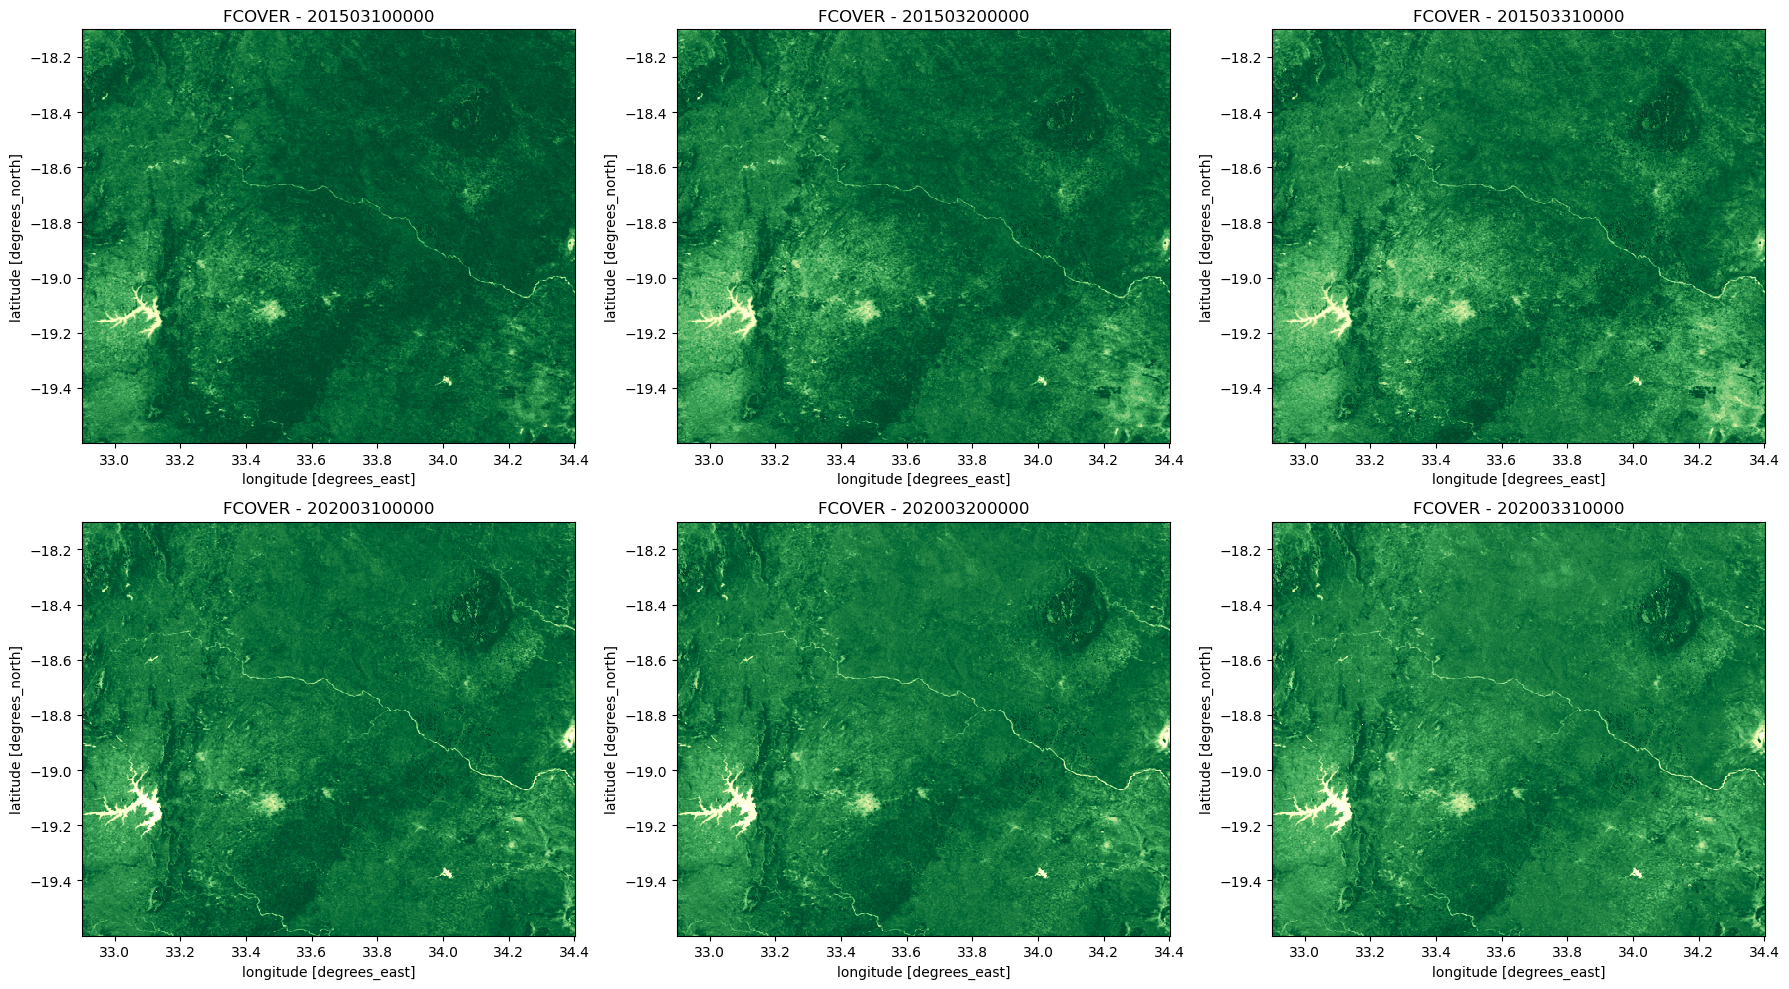

In [9]:

files_stored = {}
files_with_data = working_dir + f"/{config['dataset_analysed']}_dataset"
file_list = list(Path(files_with_data).glob("*03*.nc"))

# Create a 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()  # Make it easier to index

for i, file_to_crop in enumerate(file_list[:6]):  # Only take the first 6 for 2x3
    ds = xr.open_dataset(file_to_crop, decode_timedelta=True)
    date_str = file_to_crop.stem.split("_")[3]

    lat_name = [c for c in ds.coords if 'lat' in c.lower()][0]
    lon_name = [c for c in ds.coords if 'lon' in c.lower()][0]

    cropped = ds[config["dataset_key"]].sel(
        **{
            lat_name: slice(config["bounding_box"]["y_max"], config["bounding_box"]["y_min"]),
            lon_name: slice(config["bounding_box"]["x_min"], config["bounding_box"]["x_max"])
        }
    )

    cropped.plot(ax=axes[i], cmap="YlGn", add_colorbar=False)
    axes[i].set_title(f"{config['dataset_key']} - {date_str}")
    files_stored[date_str] = cropped

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()



0.15


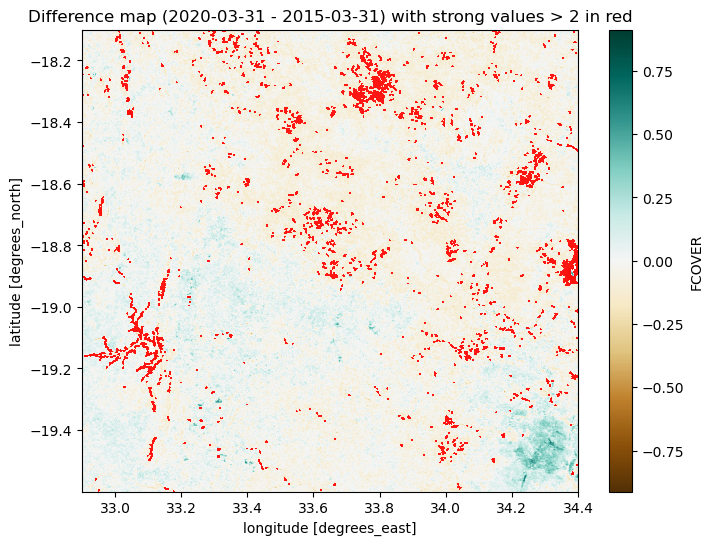

In [36]:
#
import numpy as np

#
difference = files_stored["202003310000"] - files_stored["201503310000"]
plt.figure(figsize=(8, 6))
difference.plot(cmap="BrBG")
plt.title(f"difference map")

files_stored[date_str] = cropped
print(config["threshold"])
# Overlay a mask for strong values
strong_diff = xr.where(difference < -config["threshold"], 1, np.nan)
strong_diff.plot.contourf(levels=[0.5, 1.5], colors='red', alpha=0.9, add_colorbar=False)

plt.title("Difference map (2020-03-31 - 2015-03-31) with strong values > 2 in red")
plt.show()

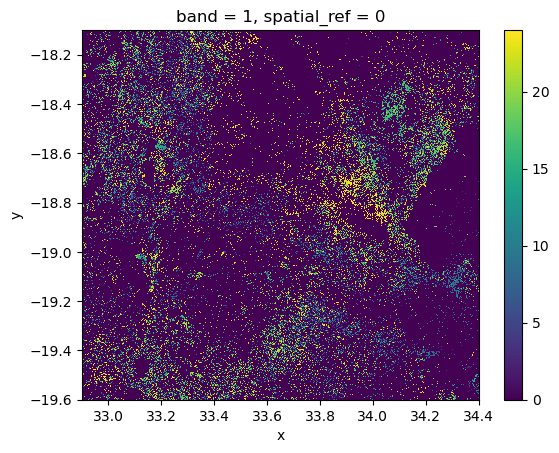

In [25]:
hansen_dir = Path(working_dir) / "hansen_dataset"
hansen_file = list((hansen_dir.glob("*")))[0]

hansen_image = rio.open_rasterio(hansen_file).isel(band=0).sel(
        **{
            "y": slice(config["bounding_box"]["y_max"], config["bounding_box"]["y_min"]),
            "x": slice(config["bounding_box"]["x_min"], config["bounding_box"]["x_max"])
        })
hansen_image.plot()
